Here we will prepare our training dataset. If you want to use another boundary values and D - define them below.

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [3]:
path = './data/'

In [4]:
def f(x):
    return torch.sin(torch.pi * x) ** 2
    
def g1(t):
    return torch.sin(4 * torch.pi * t)

def g2(t):
    return 0 * t

A, B, T = 0, 1, 0.5
D = 0.5
Nt, Nx = 500, 750

t = torch.linspace(0, T, Nt)
x = torch.linspace(A, B, Nx)

initial_values = f(x)
left_boundary = g1(t)
right_boundary = g2(t)

We use Crank-Nicholson scheme to solve this problem.

c:\Users\dlaptev\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3588.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


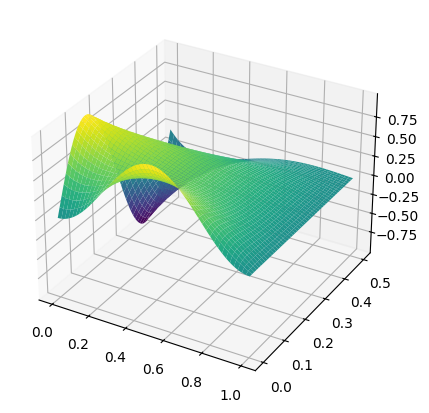

In [5]:
dx = (B - A) / Nx
dt = T / Nt
alpha = D * dt / (2 * dx ** 2)

u = torch.zeros((Nt, Nx))

u[0, :] = initial_values
u[:, 0], u[:, -1] = left_boundary, right_boundary

A_cs = torch.diag((1 + 2*alpha) * torch.ones(Nx)) + torch.diag(-alpha * torch.ones(Nx-1), 1) + torch.diag(-alpha * torch.ones(Nx-1), -1)
B_cs = torch.diag((1 - 2*alpha) * torch.ones(Nx)) + torch.diag(alpha * torch.ones(Nx-1), 1) + torch.diag(alpha * torch.ones(Nx-1), -1)
    
A_reversed = torch.linalg.inv(A_cs)

for n in range(0, Nt - 1):

    b = B_cs @ (u[n, :])
    b[0] = alpha * left_boundary[n]
    b[-1] = alpha * right_boundary[n]

    u[n+1, :] = A_reversed @ b
    
x_pts, t_pts = torch.meshgrid(x, t)

fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x_pts, t_pts, u.T, cmap='viridis')
plt.show()

In [6]:
solution = torch.stack([t_pts.flatten(), x_pts.flatten(), u.T.flatten()]).T
np.save(path + 'solution.npy', solution)

We assume that boundary values are given not as functions, but as finite collection of observations.

To imitate this approach, we will get random sample from boundary values with user-defined number of points.

In [9]:
def get_random_subset(N_I, N_A, N_B):
    init_pts = torch.rand((N_I)).sort().values * (B - A) + A
    left_pts = torch.rand((N_A)).sort().values * T
    right_pts = torch.rand((N_B)).sort().values * T

    init_data = f(init_pts)
    left_data = g1(left_pts)
    right_data = g2(right_pts)
    
    points = [
        torch.vstack([torch.zeros_like(init_pts), init_pts]).T,
        torch.vstack([left_pts, torch.ones_like(left_pts) * A]).T,
        torch.vstack([right_pts, torch.ones_like(right_pts) * B]).T,
    ]

    targets = [
        init_data.reshape(-1, 1), 
        left_data.reshape(-1, 1), 
        right_data.reshape(-1, 1)
    ]
    
    return (points, targets)

points, targets = get_random_subset(512, 512, 512)

for pts, data, name in zip(points, targets, ['init', 'left', 'right']):
    values = torch.hstack([pts, data])
    np.save(path + name + '_data.npy', values)